#  Convoluted Fashion
by Teppei Suzuki

## Introduction
dafsfasfsafdasf

## Setup
Let's first import some useful libraries and load in the fashion MNIST dataset into Panda datafame objects

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
df_train = pd.read_csv('/Users/tep/PycharmProjects/ConvolutedFashion/fashion-mnist_dataset/fashion-mnist_train.csv')
df_test = pd.read_csv('/Users/tep/PycharmProjects/ConvolutedFashion/fashion-mnist_dataset/fashion-mnist_test.csv')

Let's take a look at how to data is stored. On the 1st column, we have a number between 0-9 indicating which label the picture belongs to. On the 2nd to the 785th column, we have the pixel intensity values. Notice that 1 + (28 * 28) = 785. In other words, the 28 by 28 pictures are flattened out along with the additon of the label on its first column.

The same applies to the test dataset.

In [6]:
df_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [38]:
data_row, data_col = 28, 28
data_shape = (data_row, data_col)
data_size = data_row * data_col
class_size = 10
num_channels = 1

filter_size1 = 5          
num_filters1 = 50         

filter_size2 = 5          
num_filters2 = 100   

filter_size3 = 5          
num_filters3 = 16         

filter_size4 = 5          
num_filters4 = 36    

fc_size = 1024

In [ ]:
def oneHotVec(vec, class_size):
    size = len(vec)
    oneHotVec = np.zeros((size, class_size))
    for i in range(size):
        oneHotVec[i][vec[i]] = 1
    return oneHotVec

In [9]:
x_training_input = np.array(df_train.iloc[:, 1:])
y_training_input = np.array(df_train.iloc[:, 0])
y_training_input_onehot = oneHotVec(y_training_input, class_size)

x_test_input = np.array(df_test.iloc[:, 1:])
y_test_input = np.array(df_test.iloc[:, 0])
y_test_input_onehot = oneHotVec(y_test_input, class_size)

In [10]:
x_training_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
y_training_input

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

In [12]:
y_training_input_onehot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [13]:
def plotRandomImages(data, num):
    # create a list with random ints of size num in the range(55000)
    random = np.random.randint(0, len(data), size=num)
    
    # list of images
    images = []
    
    # add images to the list of images using the random ints
    # we have to reshape the array to 28x28 for correct plotting
    for i in range(num):
        index = random[i]
        images += [data[index].reshape(data_shape)]
    
    # plot the images
    plt.figure(figsize=(30,10))
    columns = 8
    
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap='binary')


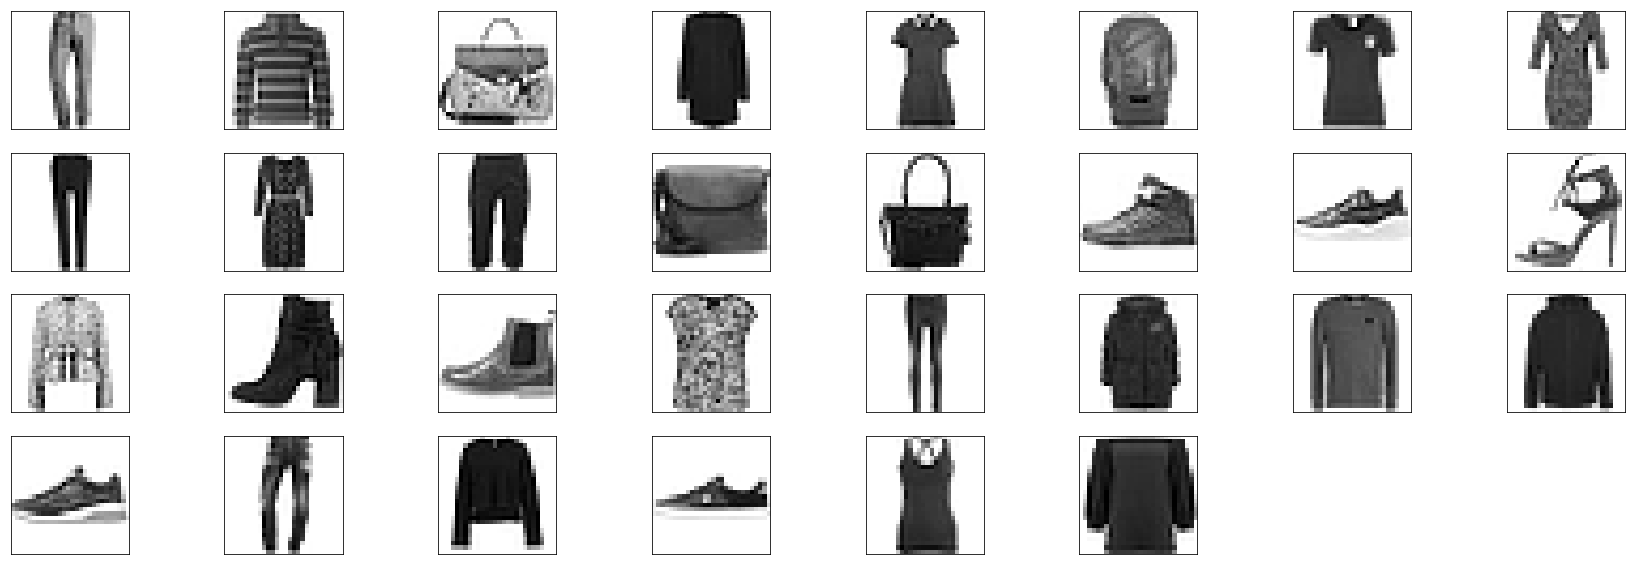

In [14]:
plotRandomImages(x_training_input, 30)

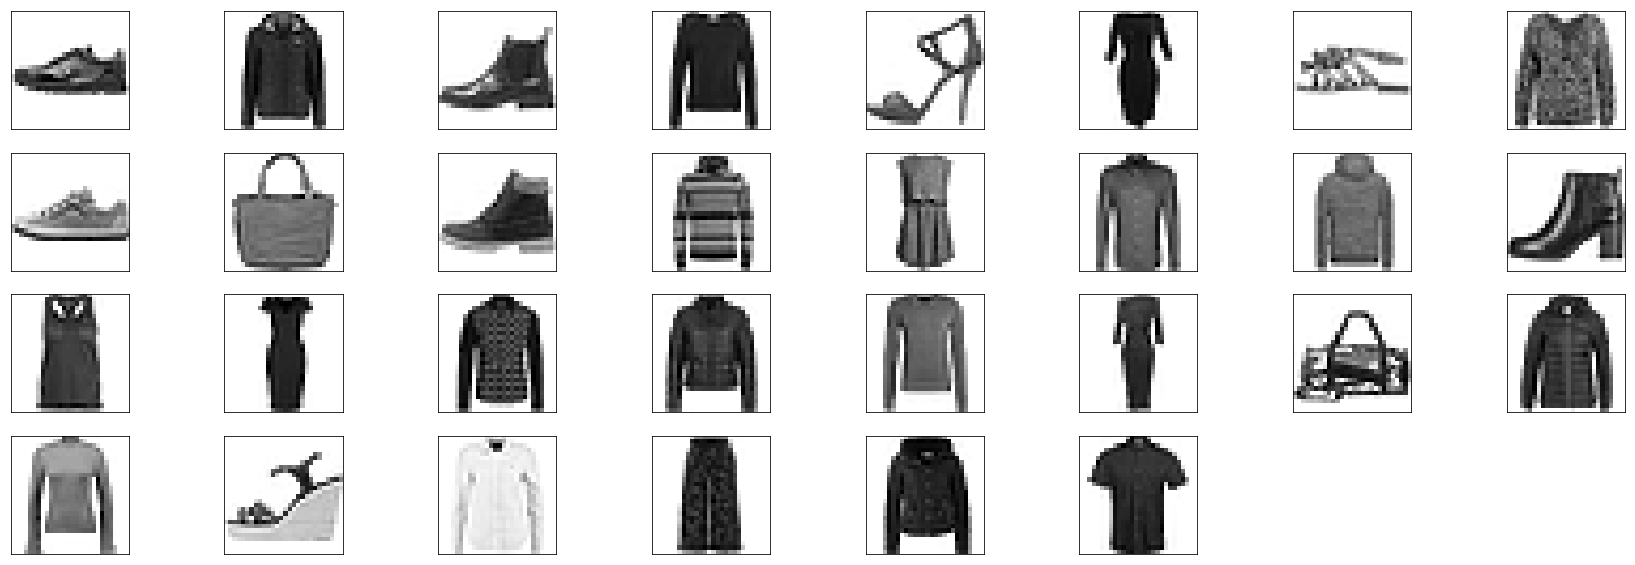

In [15]:
plotRandomImages(x_training_input, 30)

In [16]:
def create_weights(shape):
    return tf.Variable(tf.random_normal(shape))

def create_bias(size):
    return tf.Variable(tf.zeros(shape=[size]))

In [17]:
def createConvLayer(prev_layer,              
                   num_input_channels, 
                   filter_size,        
                   num_filters):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    weights = create_weights(shape)
    
    biases = create_bias(num_filters)
    
    layer = tf.nn.conv2d(input=prev_layer,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = layer + biases
    
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [39]:
x = tf.placeholder(tf.float32, shape=[None, data_size], name='x')
x_image = tf.reshape(x, [-1, data_row, data_col, num_channels])

In [40]:
y_int = tf.placeholder(tf.int64, [None])
y_one_hot = tf.placeholder(tf.float32, [None, class_size])

In [41]:
layer_conv1, weights_conv1 = \
    createConvLayer(x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

In [42]:
layer_conv2, weights_conv2 = \
    createConvLayer(layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

In [22]:
# layer_conv3, weights_conv3 = \
#     createConvLayer(layer_conv2,
#                    num_input_channels=num_filters2,
#                    filter_size=filter_size3,
#                    num_filters=num_filters3)

In [23]:
# layer_conv4, weights_conv4 = \
#     createConvLayer(layer_conv3,
#                    num_input_channels=num_filters3,
#                    filter_size=filter_size4,
#                    num_filters=num_filters4)

In [43]:
layer_2_shape = layer_conv2.shape
num_features = layer_2_shape[1:4].num_elements()
flat_conv_layer =  tf.reshape(layer_conv2, [-1, num_features])


In [44]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,
                 use_relu=True): 
    shape=[num_inputs, num_outputs]
    
    weights = create_weights(shape)
    
    biases = create_bias(num_outputs)

   
    layer = tf.matmul(input, weights) + biases    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [45]:
layer_fc1 = new_fc_layer(input=flat_conv_layer,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [46]:
# layer_fc2 = new_fc_layer(input=layer_fc1,
#                          num_inputs=fc_size,
#                          num_outputs=500,
#                          use_relu=True)

In [47]:
layer_fc3 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=class_size,
                         use_relu=False)

In [48]:
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_one_hot)
cost = tf.reduce_mean(cross_entropy)

In [49]:
optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_int)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [50]:
def next_batch(batch_size, data, labels, onehot):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    onehot_shuffle = [onehot[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle), np.asarray(onehot_shuffle)

In [51]:
num_iterations = 50000
batch_size = 50

In [52]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [53]:
for i in range(num_iterations):
        data, labels, onehot = next_batch(batch_size, x_training_input,y_training_input, y_training_input_onehot)
        
        feed_dict_train = {x: data,
                           y_one_hot: onehot}

        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 400 == 0:
            print(i)
            feed_dict_test = {x: x_test_input,
                    y_one_hot: y_test_input_onehot,
                    y_int: y_test_input}
            acc = session.run(accuracy, feed_dict=feed_dict_test)
            print("Accuracy on test-set: {0:.1%}".format(acc))

0
Accuracy on test-set: 12.2%
400
Accuracy on test-set: 80.2%
800
Accuracy on test-set: 81.7%
1200
Accuracy on test-set: 80.8%
1600
Accuracy on test-set: 83.5%
2000
Accuracy on test-set: 83.9%
2400
Accuracy on test-set: 85.5%
2800
Accuracy on test-set: 83.8%
3200
Accuracy on test-set: 86.1%
3600
Accuracy on test-set: 84.4%
4000
Accuracy on test-set: 85.6%
4400
Accuracy on test-set: 86.6%
4800
Accuracy on test-set: 85.9%
5200
Accuracy on test-set: 86.5%
5600
Accuracy on test-set: 86.8%
6000
Accuracy on test-set: 86.8%
6400
Accuracy on test-set: 87.9%
6800
Accuracy on test-set: 87.1%
7200
Accuracy on test-set: 87.3%
7600
Accuracy on test-set: 88.1%
8000
Accuracy on test-set: 87.5%
8400
Accuracy on test-set: 87.2%
8800
Accuracy on test-set: 87.8%
9200
Accuracy on test-set: 87.4%
9600
Accuracy on test-set: 87.8%
10000
Accuracy on test-set: 87.5%
10400
Accuracy on test-set: 88.1%
10800
Accuracy on test-set: 87.9%
11200
Accuracy on test-set: 87.9%
11600
Accuracy on test-set: 87.5%
12000
Accu

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-13200229ef61>", line 2, in <module>
    data, labels, onehot = next_batch(batch_size, x_training_input,y_training_input, y_training_input_onehot)
  File "<ipython-input-50-3fe70154515f>", line 12, in next_batch
    return np.asarray(data_shuffle), np.asarray(labels_shuffle), np.asarray(onehot_shuffle)
  File "C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\numpy\core\numeric.py", line 492, in asarray
    return array(a, dtype, copy=False, order=order)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\IPython\core\interactiveshell.py", line 1809, in showtraceback
    stb = value._render_traceback_()
AttributeErr

KeyboardInterrupt: 